## Example study - 1
This jupyter notebook creates plots to study the impact of placing charging stations as per two scenarios: 

- **Scenario – 1: Attempt to reduce trip infeasibility**
- **Scenario – 2: Attempt to reduce charging sessions**



### 0. Analysis IDs to compare

In [77]:
# Define the set id for the analysis_ids that we want to compare
set_id  = (78, )

### 1. Package Installs

In [78]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [79]:
# Seaborn for plotting
#!pip install seaborn

In [80]:
# Plotly for plotting 
#!pip install plotly

In [81]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import plotly.express as px

### 2. Environment Variables

In [82]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [83]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'chargeval_dev'

### 3. Database connection

In [84]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [85]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.5 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [86]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [87]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(44934,)

In [88]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(set_id,))
evs_in_sim

,count,analysis_id
0,920,445
1,917,443


In [89]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(set_id,))
evs_fin

,count,analysis_id
0,915,445
1,912,443


In [90]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(set_id,))
evs_str

,count,analysis_id
0,5,443
1,5,445


In [91]:
sql_evs_str_loc = '''select stranded_lat, stranded_lng, est.analysis_id, coalesce(ne.count, 0) as nevse_count
from ev_stranded est
         left join (
    select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on est.analysis_id = ne.analysis_id
where est.analysis_id IN (select analysis_id from analysis_record where set_id IN %s)
ORDER BY nevse_count;'''
evs_str_loc = pd.read_sql_query(sql=sql_evs_str_loc, con=conn, params=(set_id,))
evs_str_loc.head()

,stranded_lat,stranded_lng,analysis_id,nevse_count
0,48.103191,-123.341643,443,10
1,47.744348,-118.828417,443,10
2,47.813466,-117.408130,443,10
3,48.164480,-122.118822,443,10
4,46.853620,-122.295169,443,10


In [92]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(set_id,))
evmt

,sum,analysis_id
0,111548.0,445
1,110370.0,443


In [93]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(set_id,))
cs

,count,analysis_id
0,675,445
1,673,443


In [94]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN (select analysis_id from analysis_record where set_id IN %s) group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(set_id,))
ws

,count,analysis_id
0,149,445
1,177,443


In [95]:
basecase_aid = 438
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       coalesce(ne.count, 0)               as nevse_count
FROM evse_power_draw epd
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on epd.analysis_id = ne.analysis_id
WHERE epd.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
GROUP BY epd.simulation_ts, epd.analysis_id, nevse_count
ORDER BY nevse_count, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(set_id,basecase_aid))
evse_util

,analysis_id,datetime,total_power,nevse_count
0,438,2019-07-01 06:00:07,0,0
1,438,2019-07-01 06:01:07,0,0
2,438,2019-07-01 06:02:07,0,0
3,438,2019-07-01 06:03:07,0,0
4,438,2019-07-01 06:04:07,0,0
...,...,...,...,...
3671,445,2019-07-02 05:32:07,0,10
3672,445,2019-07-02 05:33:07,0,10
3673,445,2019-07-02 05:34:07,0,10
3674,445,2019-07-02 05:35:07,0,10


In [96]:
sql_new_evses = """select latitude, longitude, analysis_id from new_evses 
                    where analysis_id IN 
                                (select analysis_id from analysis_record where set_id IN %s)"""
new_evses = pd.read_sql_query(sql=sql_new_evses, con=conn, params=(set_id,))
new_evses.head()

,latitude,longitude,analysis_id
0,47.268048,-121.233669,443
1,48.625647,-122.361109,443
2,48.341646,-121.548889,443
3,47.082280,-120.732380,443
4,46.946512,-119.969614,443


In [97]:
basecase_aid = 438
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       coalesce(ne.count, 0) as nevse_count,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on ets.analysis_id = ne.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN (select analysis_id from analysis_record where set_id IN %s UNION (select %s as analysis_id))
group by ets.analysis_id, nevse_count, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(set_id,basecase_aid))
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,869,438,0,863,101095.0,6,537,102
1,917,443,10,912,110370.0,5,673,177
2,920,445,10,915,111548.0,5,675,149


In [98]:
count_stats.dtypes
count_stats = count_stats.sort_values(by=['nevse_count'])
count_stats

,sim_count,analysis_id,nevse_count,fin_count,evmt,str_count,cs_count,wait_count
0,869,438,0,863,101095.0,6,537,102
1,917,443,10,912,110370.0,5,673,177
2,920,445,10,915,111548.0,5,675,149


In [99]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       coalesce(ne.count, 0) as nevse_count,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         left join (select count(nevse_id), analysis_id from new_evses group by analysis_id) as ne
              on (lai.row_data -> 'analysis_id')::int = ne.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* (select string_agg(cast(analysis_id as text), '|') from analysis_record where set_id IN %s)
ORDER BY nevse_count
;"""
# data = '|'.join(map(str,set_id))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(set_id,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,nevse_count,time_taken_tripgen,time_taken_eviabm
0,2021-02-22 18:53:04.049966+00:00,443,2021-02-22 19:10:43.146188+00:00,2021-02-22 22:45:39.073060+00:00,# EV: 917,10,17.0,214.0
1,2021-03-01 21:07:23.161432+00:00,445,2021-03-01 21:42:32.567764+00:00,2021-03-02 02:06:39.915778+00:00,# EV: 920,10,35.0,264.0


In [100]:
basecase_aid = 438 # basecase analysis_id used for CS and WS computation
sql_be_cs = """select count(cs_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_charging_session ecs
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = ecs.evse_id 
where ecs.analysis_id = %s
group by ecs.analysis_id, ecs.evse_id, be.latitude, be.longitude
order by count desc, evse_id desc
limit 10;
"""
be_cs = pd.read_sql_query(sql=sql_be_cs, con=conn, params=(basecase_aid,))
be_cs

,count,analysis_id,evse_id,latitude,longitude
0,44,438,b73433,47.420940,-121.411300
1,42,438,b124683,48.095461,-122.186896
2,30,438,b145684,47.998233,-122.100638
3,27,438,b167497,47.188833,-120.903139
4,19,438,b65865,48.457448,-122.335866
5,19,438,b170358,46.978901,-120.543425
6,17,438,b121704,47.491288,-121.793559
7,16,438,b143970,47.913486,-122.213314
8,15,438,b124684,46.139875,-122.901263
9,14,438,b96282,47.568250,-122.667050


In [101]:
sql_be_ws = """select count(wait_id) as count, analysis_id, evse_id, be.latitude, be.longitude
from evse_evs_waiting ews
         left join built_evse be on
    'b' || cast(be.bevse_id as text) = ews.evse_id
where ews.analysis_id = %s
group by ews.analysis_id, ews.evse_id, be.latitude, be.longitude
order by count desc
limit 10;
"""
be_ws = pd.read_sql_query(sql=sql_be_ws, con=conn, params=(basecase_aid,))
be_ws.head()

,count,analysis_id,evse_id,latitude,longitude
0,39,438,b73433,47.420940,-121.411300
1,25,438,b167497,47.188833,-120.903139
2,12,438,b105362,47.467463,-120.336918
3,8,438,b65859,47.427580,-120.312310
4,4,438,b65861,46.725274,-122.974224


In [102]:
sql_nevses_cs_count = """select ne.evse_id, coalesce(count(cs_id), 0) as count, ne.analysis_id
from (select 'n' || cast(nevse_id as text) as evse_id, analysis_id
      from new_evses
      where analysis_id IN (select analysis_id from analysis_record where set_id IN %s)) ne
       left join (select * from evse_charging_session) ecs
              on ecs.evse_id = ne.evse_id
group by ne.analysis_id, ne.evse_id;"""
nevses_cs_count = pd.read_sql_query(sql=sql_nevses_cs_count, con=conn, params=(set_id,))
nevses_cs_count.head()

,evse_id,count,analysis_id
0,n988,32,443
1,n989,3,443
2,n990,2,443
3,n991,13,443
4,n992,22,443


In [104]:
nevses_cs_count_445 = nevses_cs_count.loc[nevses_cs_count.analysis_id==445]
nevses_cs_count_445

,evse_id,count,analysis_id
10,n1008,4,445
11,n1009,13,445
12,n1010,16,445
13,n1011,3,445
14,n1012,2,445
15,n1013,2,445
16,n1014,3,445
17,n1015,8,445
18,n1016,8,445
19,n1017,2,445


In [105]:
nevses_cs_count_443 = nevses_cs_count.loc[nevses_cs_count.analysis_id==443]
nevses_cs_count_443

,evse_id,count,analysis_id
0,n988,32,443
1,n989,3,443
2,n990,2,443
3,n991,13,443
4,n992,22,443
5,n993,7,443
6,n994,27,443
7,n995,22,443
8,n996,3,443
9,n997,4,443


### 5. Plotting

#### 5.1 Vehicle Counts

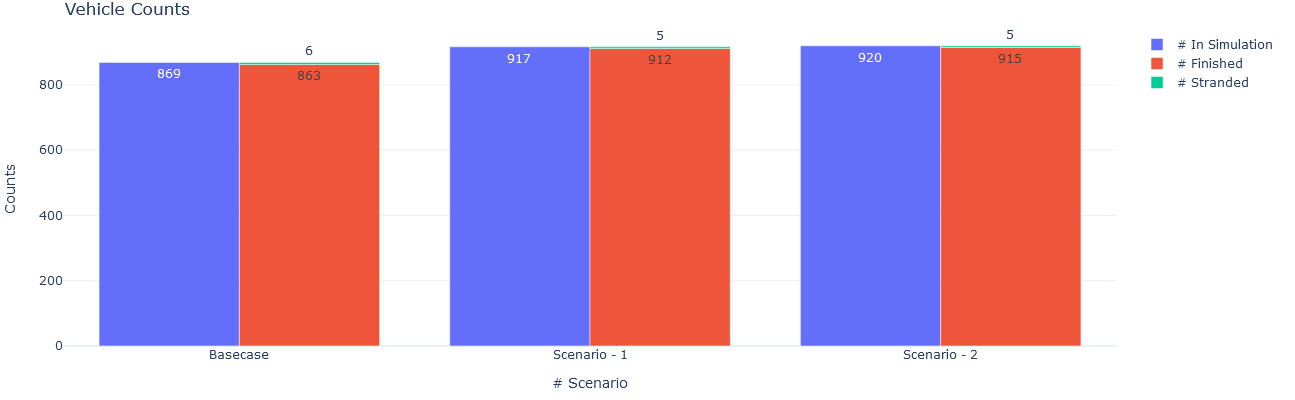

In [106]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['analysis_id'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['analysis_id'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['analysis_id'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2], ticktext=['Basecase', 'Scenario - 1', 'Scenario - 2'])
# fig.update_yaxes(range=(0, 1300))
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.2 eVMT

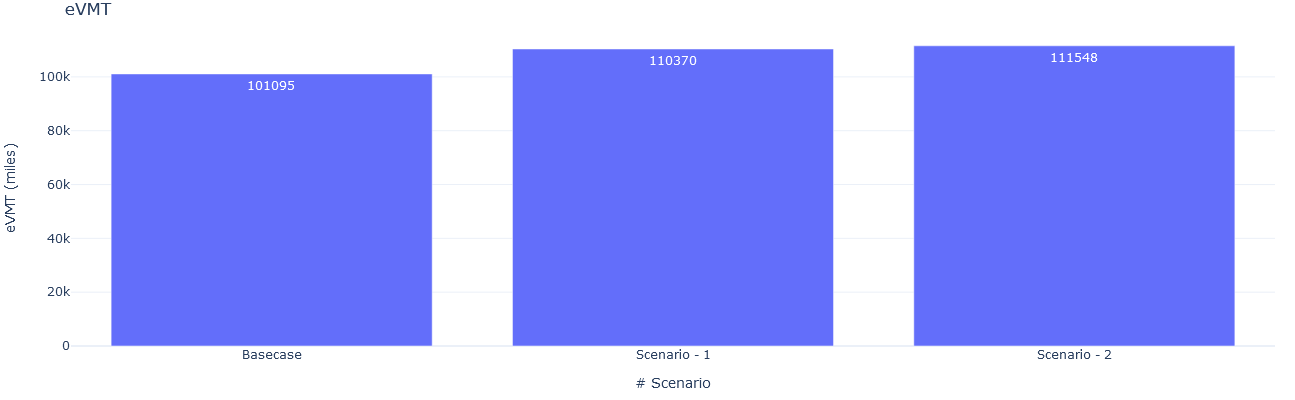

In [107]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['analysis_id'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="# Scenario", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2], ticktext=['Basecase', 'Scenario - 1', 'Scenario - 2'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

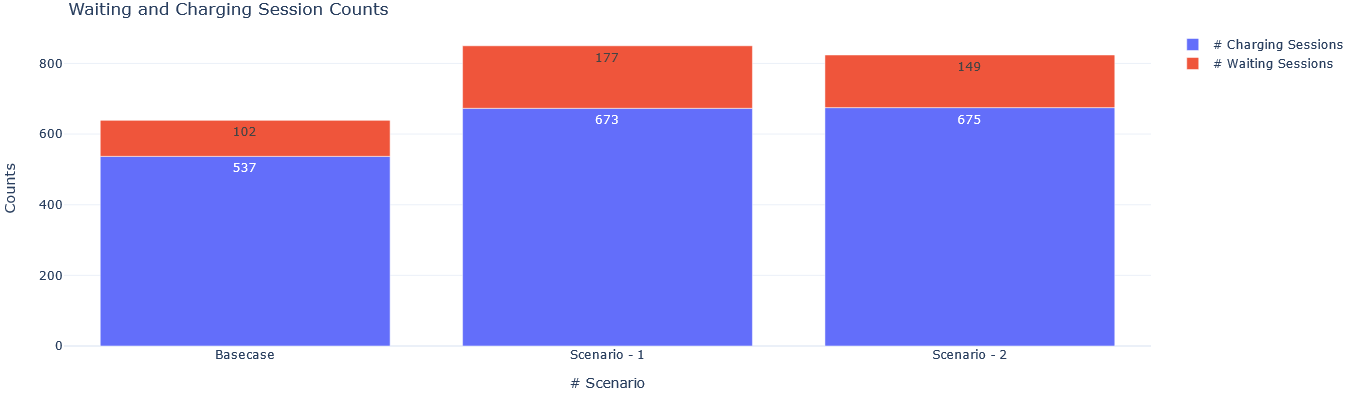

In [108]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['analysis_id'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="# Scenario", width=600, height=400
        
    )
)
fig.update_xaxes(type='category', tickvals=[0, 1, 2], ticktext=['Basecase', 'Scenario - 1', 'Scenario - 2'])
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

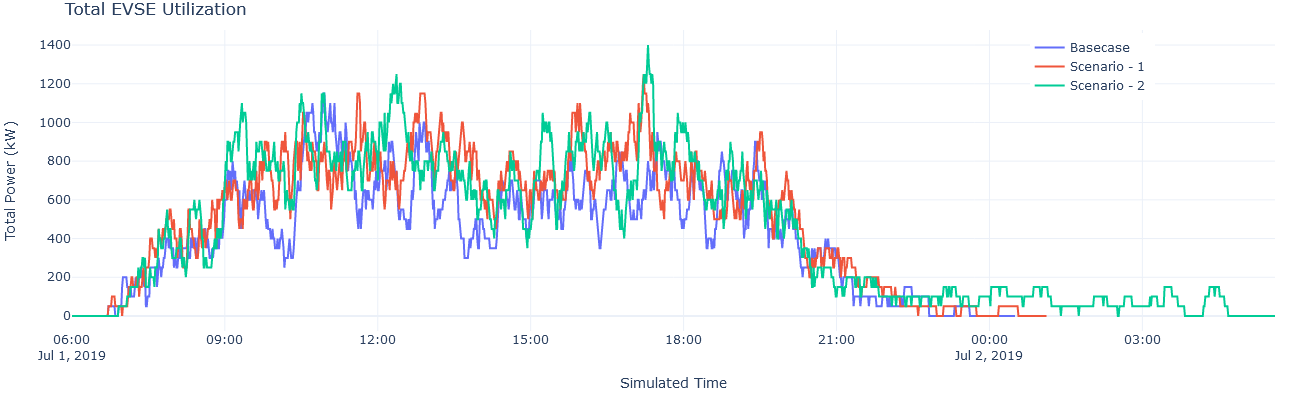

In [109]:
#fig = px.line(evse_util, x="datetime", y="total_power", color='analysis_id', name=['Basecase', 'Scenario - 1', 'Scenario - 2', 'Scenario - 3'], range_x=['2019-07-01 06:00','2019-07-02'])

fig = go.Figure()
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 438]['datetime'], y=evse_util[evse_util['analysis_id'] == 438]['total_power'],
                    mode='lines',
                    name='Basecase'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 443]['datetime'], y=evse_util[evse_util['analysis_id'] == 443]['total_power'],
                    mode='lines',
                    name='Scenario - 1'))
fig.add_trace(go.Scatter(x=evse_util[evse_util['analysis_id'] == 445]['datetime'], y=evse_util[evse_util['analysis_id'] == 445]['total_power'],
                    mode='lines',
                    name='Scenario - 2'))


fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white', showlegend=True, legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.9
))
fig.show()

In [112]:
token = os.getenv("MAPBOX_ACCESS_TOKEN")
analysis_ids = new_evses['analysis_id'].unique()

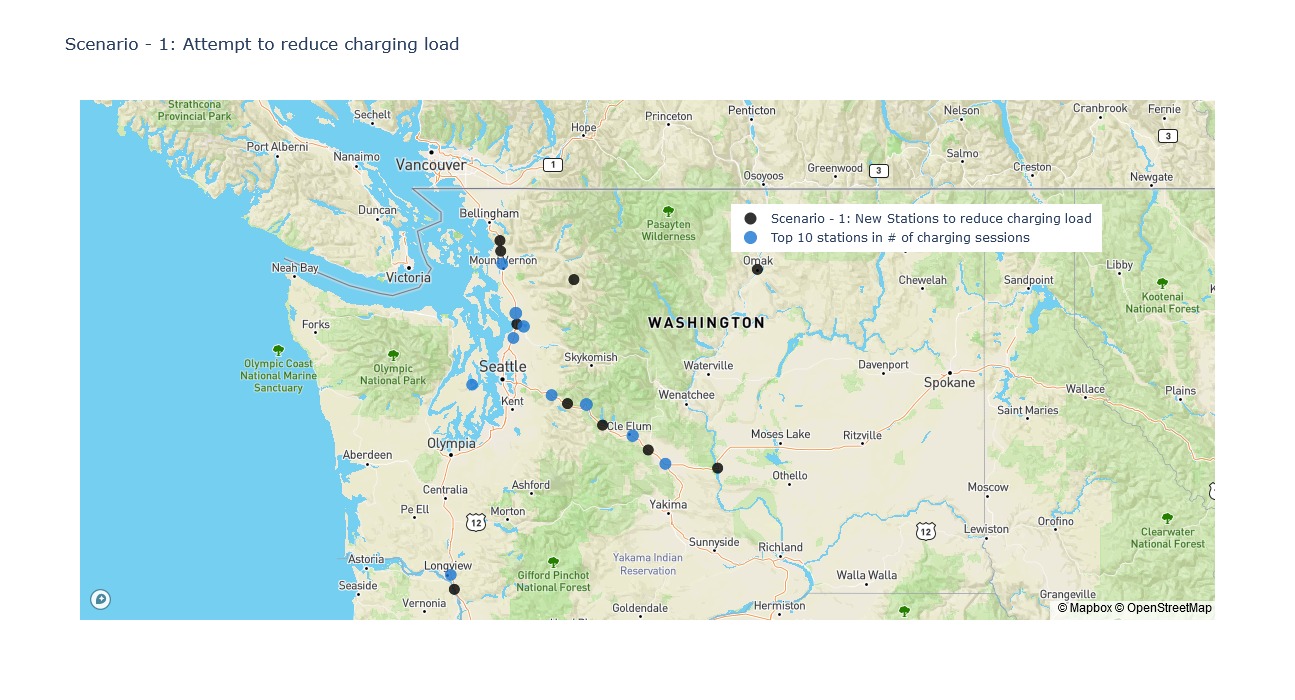

In [116]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=new_evses[new_evses['analysis_id'] == analysis_ids[0]]['latitude'],
        lon=new_evses[new_evses['analysis_id'] == analysis_ids[0]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(0, 0, 0)',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Scenario - 1: New Stations to reduce charging load'
    ))

fig.add_trace(go.Scattermapbox(
        lat=be_cs['latitude'],
        lon=be_cs['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10+np.log(be_cs['count']),
            color='#1976D2',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Top 10 stations in # of charging sessions'
    ))

fig.update_layout(
        title_text = 'Scenario - 1: Attempt to reduce charging load',
        showlegend = True,
        mapbox_style="streets", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.8,
    xanchor="right",
    x=0.9
)
    )

fig.show()

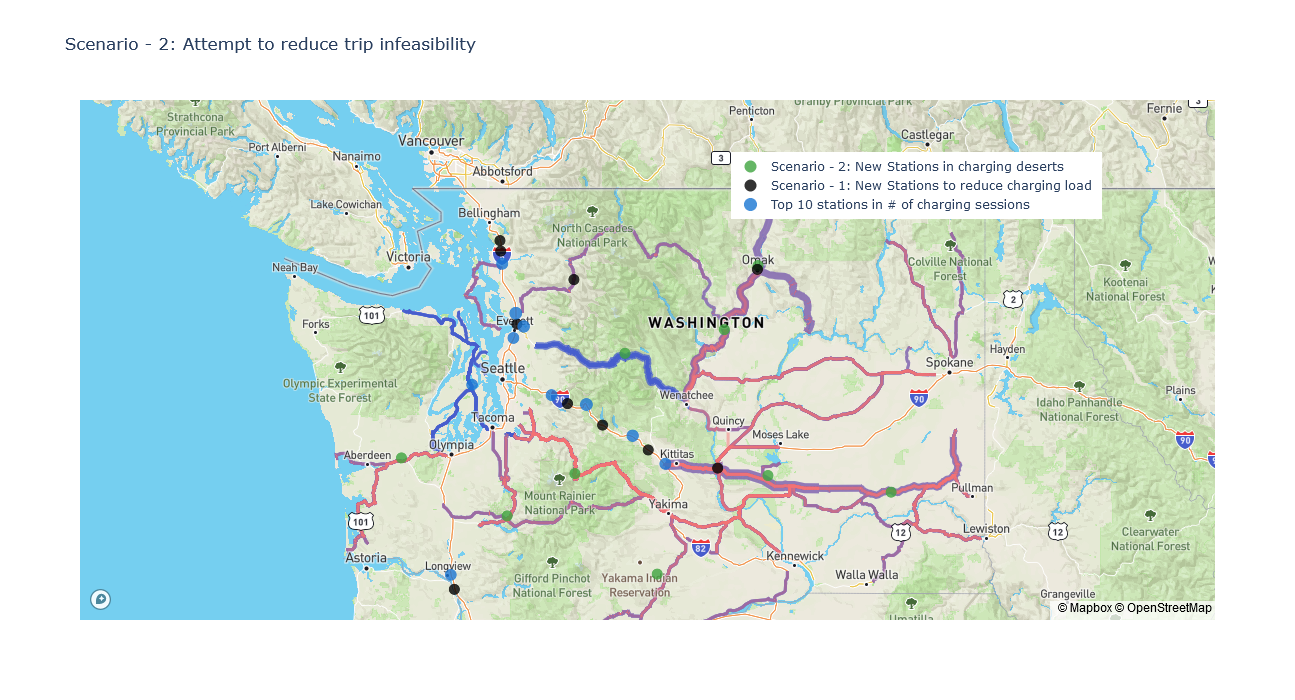

In [122]:
fig = go.Figure()
fig.add_trace(go.Scattermapbox(
        lat=new_evses[new_evses['analysis_id'] == analysis_ids[1]]['latitude'],
        lon=new_evses[new_evses['analysis_id'] == analysis_ids[1]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='#3FA43F',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Scenario - 2: New Stations in charging deserts'
    ))

fig.add_trace(go.Scattermapbox(
        lat=new_evses[new_evses['analysis_id'] == analysis_ids[0]]['latitude'],
        lon=new_evses[new_evses['analysis_id'] == analysis_ids[0]]['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=12,
            color='rgb(0, 0, 0)',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Scenario - 1: New Stations to reduce charging load'
    ))

fig.add_trace(go.Scattermapbox(
        lat=be_cs['latitude'],
        lon=be_cs['longitude'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10+np.log(be_cs['count']),
            color='#1976D2',
            opacity=0.8
        ),
        hoverinfo='none', 
    name='Top 10 stations in # of charging sessions'
    ))

fig.update_layout(
        title_text = 'Scenario - 2: Attempt to reduce trip infeasibility',
        showlegend = True,
        mapbox_style="mapbox://styles/chintanp/ckhmnh3oa01r419pkc9qgn0sq", mapbox_accesstoken=token,
        mapbox_zoom=6, mapbox_center = {"lat":  47.7511, "lon": -120.7401}, 
        width=1000, 
        height=700, legend=dict(
    yanchor="top",
    y=0.9,
    xanchor="right",
    x=0.9
)
    )

fig.show()

In [65]:
sum(nevses_cs_count_444['count'])

48

/root/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:322: DeprecationWarning:

plotly.graph_objs.Font is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Font
  - plotly.graph_objs.layout.hoverlabel.Font
  - etc.


/root/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:143: DeprecationWarning:

plotly.graph_objs.Annotation is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation


/root/anaconda3/lib/python3.8/site-packages/plotly/graph_objs/_deprecations.py:62: DeprecationWarning:

plotly.graph_objs.Annotations is deprecated.
Please replace it with a list or tuple of instances of the following types
  - plotly.graph_objs.layout.Annotation
  - plotly.graph_objs.layout.scene.Annotation




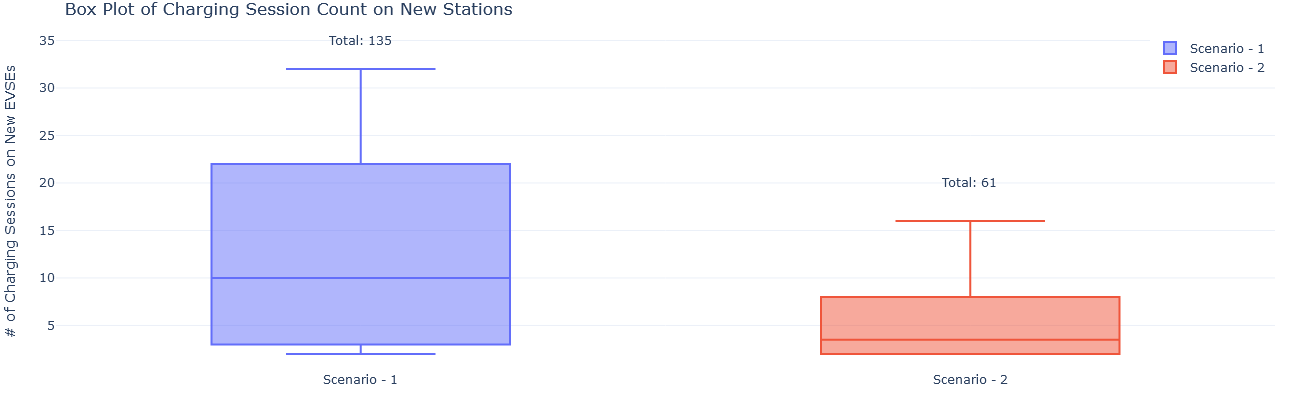

In [115]:
layout = go.Layout(
    annotations=go.Annotations([
        go.Annotation(
            x=0,
            y=35,
            text='Total: ' + str(sum(nevses_cs_count_443['count'])),
            showarrow=False,
            font=go.Font(
                size=12
            )
        ), go.Annotation(
            x=1,
            y=20,
            text='Total: ' + str(sum(nevses_cs_count_445['count'])),
            showarrow=False,
            font=go.Font(
                size=12
            )
        )
    ])
)

fig = go.Figure(layout=layout)
fig.add_trace(go.Box(y=nevses_cs_count_443['count'], name = 'Scenario - 1', text = sum(nevses_cs_count_443['count'])))
fig.add_trace(go.Box(y=nevses_cs_count_445['count'], name = 'Scenario - 2'))


fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white', width=600, height=400, title="Box Plot of Charging Session Count on New Stations",
                  yaxis_title="# of Charging Sessions on New EVSEs", legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=1.0
))
fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [35]:
#!jupyter labextension list

In [36]:
#!jupyter labextension uninstall jupyterlab-plotly

In [37]:
#!jupyter labextension uninstall plotlywidget

In [38]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [39]:
#!pip show plotly

In [40]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [41]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [42]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [43]:
#!pip install "nbconvert<6"